<a href="https://colab.research.google.com/github/camdsDS/Cesar_Portfolio/blob/main/Porto_Seguro_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Evita avisos desnecessários para a apresentação ficar limpa
import warnings
warnings.filterwarnings('ignore')

# Funções

In [2]:
def relatorio(data, target):
    '''
    Devolve um relatorio sobre valores miss no df, valor da bad rate,
    tipos de dados e correlação de Pearson     
    '''
    #Relatorio de miss
    df_miss = ((data.isna().sum()/len(data))*100).to_frame().reset_index().rename(columns={'index': 'column', 0:'%_miss'}).sort_values('%_miss', ascending = False)
    if df_miss['%_miss'].tolist()[0] == 0:
        print('O df não apresenta valores miss.')
    else:
        print('O df apresenta valores miss e as cinco colunas com maior concentração de miss são:')
        print(df_miss.head())
        
    bad_rate = data[target].value_counts()[1]/(data[target].value_counts()[0]+data[target].value_counts()[1])
    print(f'\nBad_rate (razão entre quantidade de 1 no target e o total (0 e 1) de valores no target: {bad_rate:.2f}')

    p0 = (data[target].value_counts()[0]/(data[target].value_counts()[0]+data[target].value_counts()[1]))*100
    p1 = bad_rate*100
    objects = ('0', '1')
    y_pos = [0,1]
    performance = [p0,p1]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('%')
    plt.title('Comparando as proporções de 0 e 1 do target')

    plt.show()

    #Correlação de Pearson
    corr_matrix = data.corr()
    corr_matrix = corr_matrix[target].to_frame().reset_index().rename(columns={'index': 'coluna', target:'correlacao'}).sort_values('correlacao', ascending = False)
    print('Correlacao de Pearson: (5 primeiras linhas)')
    print(corr_matrix.head())

In [3]:
def RelatorioMiss(df):
    '''
    Retorna a % de miss de cada coluna do df
    '''
    df_miss = ((df.isna().sum()/len(df))*100).to_frame().rename(columns={0:'P_miss'}).reset_index().sort_values('P_miss', ascending = False)
    return df_miss

In [4]:
def unique_df(df,x):
    '''
    Função para ver, se houver, x elementos únicos de cada coluna de um df
    '''    
    rows = np.arange(x).tolist()
    unique = pd.DataFrame(rows,columns={"index"})
    for i in df.columns:
        u = df[i].unique()
        a = pd.DataFrame(u,columns=[i])
        try:
            a.sort_values(i,inplace=True)
        except:
            a = a
        unique=unique.merge(a,how="left",left_index=True,right_index=True)
    unique.fillna("",inplace=True)
    unique.drop("index",axis=1,inplace=True)
    return unique

In [5]:
def normalizacao(df):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(df)

    abt = pd.DataFrame(scaler.transform(df), columns = df.columns)
    abt.index = df.index
    return abt

In [6]:
def roccurve(y_train,y_pred_train,y_score_train,y_test,y_pred_test,y_score_test,titulo=""):
    '''
    y_pred_train:  #predict do desenv
    y_score_train: #proba mau do desenv
    y_train: #target do desenv
    y_pred_test: #predict da valid
    y_score_test: #proba mau da valid
    y_test: #target da valid
    titulo: "titulo"  #título

    exemplo: roccurve(y_train,y_pred_train,y_score_train,y_test,y_pred_test,y_score_test,titulo)
    '''
    # 1) Cálculo da acurácia
    from sklearn.metrics import accuracy_score

    #Treino
    acc_train = round(accuracy_score(y_pred_train, y_train) * 100, 2)

    #Teste
    acc_test = round(accuracy_score(y_pred_test, y_test) * 100, 2)

    # 2) Cálculo da área sob curva ROC e Gini
    from sklearn.metrics import roc_curve, auc

    # Treino
    fpr_train, tpr_train, thresholds = roc_curve(y_train, y_score_train)
    roc_auc_train = round(100*auc(fpr_train, tpr_train),2)
    gini_train = 100*round((2*roc_auc_train/100 - 1), 2)

    # Teste
    fpr_test, tpr_test, thresholds = roc_curve(y_test, y_score_test)
    roc_auc_test = round(100*auc(fpr_test, tpr_test),2)
    gini_test = 100*round((2*roc_auc_test/100 - 1), 2)


    # 3) Gráfico da curva ROC
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(12,6))

    lw = 2

    plt.plot(fpr_train, tpr_train, color='blue',lw=lw, label='ROC (Desenv = %0.0f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',lw=lw, label='ROC (Valid = %0.0f)' % roc_auc_test)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo', fontsize=15)
    plt.ylabel('Verdadeiro Positivo', fontsize=15)
    plt.legend(loc="lower right")
    plt.legend(fontsize=20) 
    plt.title(titulo, fontsize=20)
    plt.show()
    
    print(f'Base de Desenv\nAcurácia: {acc_train}, Gini: {gini_train} e Área Curva ROC: {roc_auc_train}')
    print(f'\nBase de Valid\nAcurácia: {acc_test}, Gini: {gini_test} e Área Curva ROC: {roc_auc_test}\n\n')

# Dados (importação e tratamento da base de treino)

**Data Description**

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [7]:
data = pd.read_csv(r'/content/drive/MyDrive/Data science/Machine Learning/kaggle/Porto Seguro/train.csv', na_values=-1)
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10.0,1.0,NaN,0,1.0,4,1.0,0,0.0,1,12,2.0,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,19,3.0,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,NaN,7.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,60,1.0,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7.0,1.0,0.0,0,1.0,11,1.0,1,3.0,1,104,1.0,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,82,3.0,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


## Relatório dos dados disponíveis

O df apresenta valores miss e as cinco colunas com maior concentração de miss são:
           column     %_miss
25  ps_car_03_cat  69.089837
27  ps_car_05_cat  44.782531
22      ps_reg_03  18.106490
37      ps_car_14   7.160474
29  ps_car_07_cat   1.930237

Bad_rate (razão entre quantidade de 1 no target e o total (0 e 1) de valores no target: 0.04


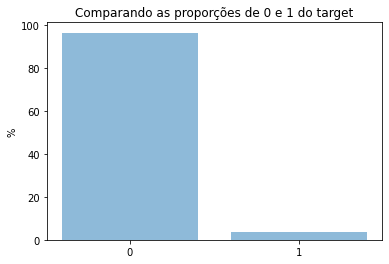

Correlacao de Pearson: (5 primeiras linhas)
           coluna  correlacao
1          target    1.000000
36      ps_car_13    0.053899
35      ps_car_12    0.038800
18  ps_ind_17_bin    0.037053
21      ps_reg_02    0.034800


In [8]:
relatorio(data, 'target')

## Definindo alvo e os df de treino, que são: df binário, df categórico de alta cardinalidade, df categórico de baixa cardinalidade e df numérico

In [9]:
data_train = data.copy()

y = data_train['target']
data_train = data_train.drop(['id','target'], axis=1)

### df categórico de alta cardinalidade e baixa cardinalidade

In [10]:
lista_colunas_cat = []
for column in data_train.columns:
    temp = column.split('_')
    for i in temp:
        if i == 'cat':
            lista_colunas_cat.append(column)

unique_df(data_train[lista_colunas_cat],10)

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
0,2,1,0,10.0,1,,0,1,4,1,0,0,1,12
1,1,0,1,11.0,0,0,1,,11,,1,2,0,19
2,4,,4,7.0,,1,8,0,14,0,,3,2,60
3,3,,3,6.0,,,9,,13,,,1,,104
4,,,6,9.0,,,2,,6,,,,,82
5,,,5,5.0,,,6,,15,,,4,,99
6,,,,4.0,,,3,,3,,,,,30
7,,,2,8.0,,,7,,0,,,,,68
8,,,,3.0,,,4,,1,,,,,20
9,,,,0.0,,,5,,10,,,,,36


In [11]:
df_categoricoAltaC = data_train[['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_11_cat']]
df_categoricoBaixaC = data_train[['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat']]

### df binário

In [12]:
lista_colunas_binarios = []
for column in data_train.columns:
    temp = column.split('_')
    for i in temp:
        if i == 'bin':
            lista_colunas_binarios.append(column)

df_binario = data_train[lista_colunas_binarios]

### df numérico

In [13]:
df_numerico = data_train.drop(lista_colunas_binarios, axis=1)
df_numerico = df_numerico.drop(lista_colunas_cat, axis=1)

#### verificando se nenhuma coluna ficou de fora de alguma df

In [14]:
a = len(df_binario.columns)
b = len(df_categoricoAltaC.columns)
c = len(df_categoricoBaixaC.columns)
d = len(df_numerico.columns)
total = len(data_train.columns)

total == a + b + c + d

True

## Tratando os dataframes

### binário

In [15]:
RelatorioMiss(df_binario).head()

,index,P_miss
0,ps_ind_06_bin,0.0
9,ps_ind_17_bin,0.0
15,ps_calc_19_bin,0.0
14,ps_calc_18_bin,0.0
13,ps_calc_17_bin,0.0


### Categórico de alta cardinalidade



In [16]:
RelatorioMiss(df_categoricoAltaC).head()

,index,P_miss
0,ps_car_01_cat,0.017977
1,ps_car_04_cat,0.000000
2,ps_car_06_cat,0.000000
3,ps_car_11_cat,0.000000


In [17]:
df_categoricoAltaC = df_categoricoAltaC.fillna('Miss')

In [18]:
for column in df_categoricoAltaC.columns:
    df_categoricoAltaC[column] = df_categoricoAltaC[column].apply(lambda x: str(x) +'_categorico')

In [19]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

df_categoricoAltaC_encodado = df_categoricoAltaC.copy()

for column in df_categoricoAltaC.columns:
    df_categoricoAltaC_encodado[column] = LE.fit_transform(df_categoricoAltaC_encodado[column])

### Categórico de baixa cardinalidade

In [20]:
RelatorioMiss(df_categoricoBaixaC).head()

,index,P_miss
4,ps_car_03_cat,69.089837
5,ps_car_05_cat,44.782531
6,ps_car_07_cat,1.930237
2,ps_ind_05_cat,0.975955
8,ps_car_09_cat,0.095596


In [21]:
for column in df_categoricoBaixaC.columns:
    df_categoricoBaixaC[column] = df_categoricoBaixaC[column].apply(lambda x: str(x) +'_categorico')

In [22]:
df_categoricoBaixaC_dummy = pd.get_dummies(df_categoricoBaixaC, dummy_na = False, drop_first=True)

### Numérico

In [23]:
RelatorioMiss(df_numerico).head()

,index,P_miss
6,ps_reg_03,18.106490
10,ps_car_14,7.160474
7,ps_car_11,0.000840
8,ps_car_12,0.000168
0,ps_ind_01,0.000000


In [24]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df_numerico)
df_numerico_tratado = pd.DataFrame(imp_mean.transform(df_numerico), columns=df_numerico.columns)
df_numerico_tratado.index = df_numerico.index

## Juntando os df

In [25]:
#df2 = df_categoricoBaixaC_dummy + df_binario
#df3 = df_categoricoAltaC_encodado + df_numerico_tratado
#df4 = df2 + df3

df2 = pd.merge(df_categoricoBaixaC_dummy, df_binario, how='left', left_index= True, right_index= True)
df3 = pd.merge(df_categoricoAltaC_encodado, df_numerico_tratado, how= 'left', left_index= True, right_index= True)
df4 = pd.merge(df2, df3, how= 'left', left_index= True, right_index= True)

## Normalização dos dados

In [26]:
abt_train = normalizacao(df4)

#### Testando modelos

In [27]:
from sklearn.model_selection import train_test_split

X_desenv, X_valid, y_desenv, y_valid = train_test_split(abt_train, y, train_size = 0.7, test_size = 0.3, random_state = 42)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

RF = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_depth=6, 
                            min_samples_split=2, 
                            min_samples_leaf=1)
RF.fit(X_desenv, y_desenv)

LR = LogisticRegression()
LR.fit(X_desenv, y_desenv)

GB = GradientBoostingClassifier()
GB.fit(X_desenv, y_desenv)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

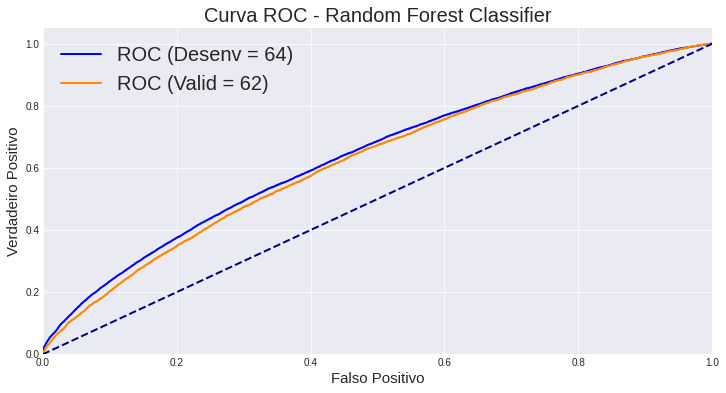

Base de Desenv
Acurácia: 96.37, Gini: 28.000000000000004 e Área Curva ROC: 63.87

Base de Valid
Acurácia: 96.31, Gini: 25.0 e Área Curva ROC: 62.47




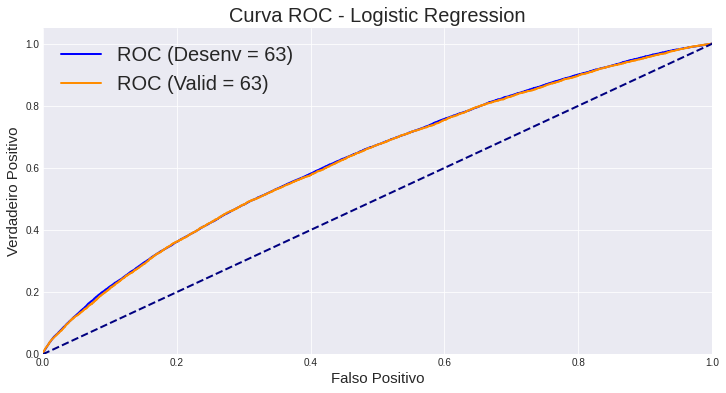

Base de Desenv
Acurácia: 96.37, Gini: 26.0 e Área Curva ROC: 62.9

Base de Valid
Acurácia: 96.31, Gini: 25.0 e Área Curva ROC: 62.69




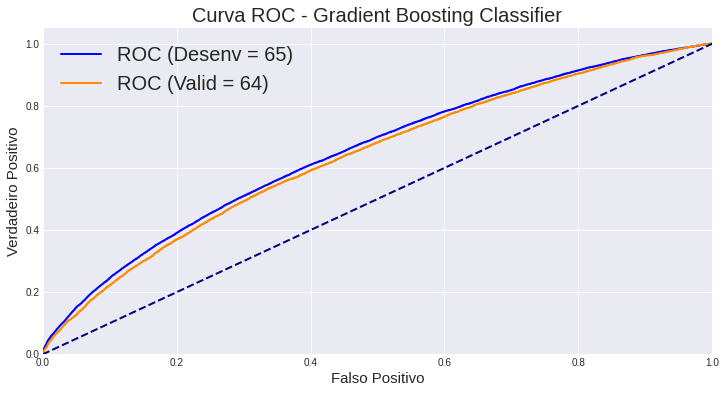

Base de Desenv
Acurácia: 96.38, Gini: 30.0 e Área Curva ROC: 64.99

Base de Valid
Acurácia: 96.31, Gini: 27.0 e Área Curva ROC: 63.53




In [29]:
lista = [RF, LR, GB]
lista_nome = ['Random Forest Classifier', 'Logistic Regression', 'Gradient Boosting Classifier']
n=0
for i in lista:
    model = i
    y_pred_train = model.predict(X_desenv)
    y_score_train = model.predict_proba(X_desenv)[:,1]
    y_train = y_desenv
    y_pred_test = model.predict(X_valid)
    y_score_test = model.predict_proba(X_valid)[:,1]
    y_test = y_valid
    titulo = f"Curva ROC - {lista_nome[n]}"
    n+=1

    roccurve(y_train,y_pred_train,y_score_train,y_test,y_pred_test,y_score_test,titulo)

#### Calibrando o melhor modelo

In [30]:
# Como o score do kaggle considera a Gini, então o melhor modelo é o Gradient Boosting
model = GradientBoostingClassifier()

parametros = {'n_estimators':[100],
              'max_depth':[6] }

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = model,        
                    param_grid = parametros,  
                    cv = 3)  

# Treinando o grid.
grid.fit(X_desenv, y_desenv)

best_params = grid.best_params_

# Imprimindo as colunas de interesse do resultado.
print('\nOs melhores parametros sao: ')
print(best_params)


Os melhores parametros sao: 
{'max_depth': 6, 'n_estimators': 100}


#### Importância das variáveis

In [31]:
model = grid.best_estimator_
model.fit(abt_train,y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [32]:
pd.options.display.max_rows = 500
var_e_imp = pd.DataFrame({'Variaveis':abt_train.columns.tolist(), 'Importancia':model.feature_importances_.tolist()}).sort_values('Importancia', ascending=False).reset_index(drop=True)
var_e_imp

,Variaveis,Importancia
0,ps_car_13,0.162830
1,ps_reg_03,0.071578
2,ps_ind_03,0.051924
3,ps_car_14,0.044893
4,ps_ind_17_bin,0.034369
5,ps_ind_15,0.031455
6,ps_reg_02,0.030177
7,ps_calc_10,0.026051
8,ps_ind_01,0.025422
9,ps_car_01_cat,0.024670


## Dropando as colunas de pouca importância e fazendo um novo modelo

In [102]:
colunas_pouca_importancia = var_e_imp[var_e_imp['Importancia']<0.001].iloc[:,0].tolist()

In [103]:
abt_train2 = abt_train.drop(colunas_pouca_importancia, axis=1)

In [104]:
X_desenv2, X_valid2, y_desenv2, y_valid2 = train_test_split(abt_train2, y, train_size = 0.7, test_size = 0.3, random_state = 42)

In [105]:
grid2 = GridSearchCV(estimator = GradientBoostingClassifier(),        
                    param_grid = parametros,  
                    cv = 3)  

grid2.fit(X_desenv2, y_desenv2)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

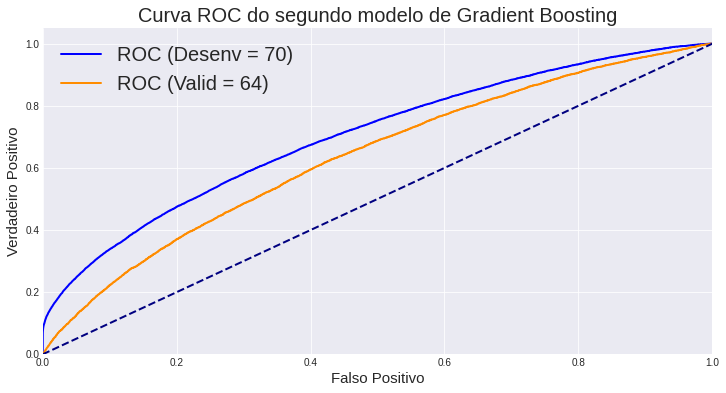

Base de Desenv
Acurácia: 96.43, Gini: 40.0 e Área Curva ROC: 70.13

Base de Valid
Acurácia: 96.29, Gini: 27.0 e Área Curva ROC: 63.54




In [106]:
y_pred_train2 = grid2.predict(X_desenv2)
y_score_train2 = grid2.predict_proba(X_desenv2)[:,1]
y_train2 = y_desenv2
y_pred_test2 = grid2.predict(X_valid2)
y_score_test2 = grid2.predict_proba(X_valid2)[:,1]
y_test2 = y_valid2
titulo = "Curva ROC do segundo modelo de Gradient Boosting"

roccurve(y_train2,y_pred_train2,y_score_train2,y_test2,y_pred_test2,y_score_test2,titulo)

## Selecionando modelo

#### Ao dropar algumas colunas podemos perceber um significativo afastamento das curvas de desenv e valid, o que sugere que o drop, mesmo sendo relativamente pequeno, pode estar causando overfitting. Assim, decidimos usar o modelo definido antes do drop.

# Base de teste

In [117]:
data2 = pd.read_csv(r'/content/drive/MyDrive/Data science/Machine Learning/kaggle/Porto Seguro/test.csv', na_values=-1)
data_test = data2.copy()

In [118]:
data_test = data_test.drop(['id'], axis=1)

df_test_categoricoAltaC = data_test[['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_11_cat']]
df_test_categoricoBaixaC = data_test[['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat']]
df_test_binario = data_test[lista_colunas_binarios]

df_test_numerico = data_test.drop(lista_colunas_binarios, axis=1)
df_test_numerico = df_test_numerico.drop(lista_colunas_cat, axis=1)

In [119]:
a_test = len(df_test_binario.columns)
b_test = len(df_test_categoricoAltaC.columns)
c_test = len(df_test_categoricoBaixaC.columns)
d_test = len(df_test_numerico.columns)
total_test = len(data_test.columns)

total_test == a + b + c + d

True

In [120]:
df_test_categoricoAltaC = df_test_categoricoAltaC.fillna('Miss')

for column in df_test_categoricoAltaC.columns:
    df_test_categoricoAltaC[column] = df_test_categoricoAltaC[column].apply(lambda x: str(x) +'_categorico')

LE = LabelEncoder()

df_test_categoricoAltaC_encodado = df_test_categoricoAltaC.copy()

for column in df_test_categoricoAltaC.columns:
    df_test_categoricoAltaC_encodado[column] = LE.fit_transform(df_test_categoricoAltaC_encodado[column])

In [121]:
for column in df_test_categoricoBaixaC.columns:
    df_test_categoricoBaixaC[column] = df_test_categoricoBaixaC[column].apply(lambda x: str(x) +'_categorico')

df_test_categoricoBaixaC_dummy = pd.get_dummies(df_test_categoricoBaixaC, dummy_na = False, drop_first=True)

In [122]:
imp_mean_test = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean_test.fit(df_numerico)
df_test_numerico_tratado = pd.DataFrame(imp_mean.transform(df_test_numerico), columns=df_test_numerico.columns)
df_test_numerico_tratado.index = df_test_numerico.index

In [123]:
#df2_test = df_categoricoBaixaC_dummy + df_binario
#df3_test = df_categoricoAltaC_encodado + df_numerico_tratado
#df4_test = df2 + df3

df2_test = pd.merge(df_test_categoricoBaixaC_dummy, df_test_binario, how='left', left_index= True, right_index= True)
df3_test = pd.merge(df_test_categoricoAltaC_encodado, df_test_numerico_tratado, how= 'left', left_index= True, right_index= True)
df4_test = pd.merge(df2_test, df3_test, how= 'left', left_index= True, right_index= True)

In [124]:
abt_test = normalizacao(df4_test)

In [125]:
# Como abt_test.columns == abt_train.columns, podemos ir para última etapa 
pred_test = grid.predict_proba(abt_test)[:,1]

output = pd.DataFrame({'id': data2['id'], 'target': pred_test})
output.to_csv('Submission_PortoSeguro.csv', index=False)